# Wireless Lab

## 1.0. Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1.0. Debug functions

In [2]:
"""
Draw the power distribution graph
"""
def powerDistributionGraph(Z, title="", x_label="", y_label=""):
    fig, ax = plt.subplots()
    cs = ax.contourf(np.linspace(0, len(Z[0]), len(Z[0])), np.linspace(0, len(Z), len(Z)), Z)
    cbar = fig.colorbar(cs)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

## 1.1. Extraction of the time frequency matrix

Size of raw matrix:  (14, 1024)
Size of the matrix with only subcarriers:  (14, 624)
Size of the matrix with only subcarriers and useful channel:  (12, 624)


/home/mathis/.local/lib/python3.10/site-packages/matplotlib/contour.py:1454: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = float(z.max())
/home/mathis/.local/lib/python3.10/site-packages/matplotlib/contour.py:1455: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = float(z.min())
/usr/lib/python3/dist-packages/numpy/ma/core.py:2829: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


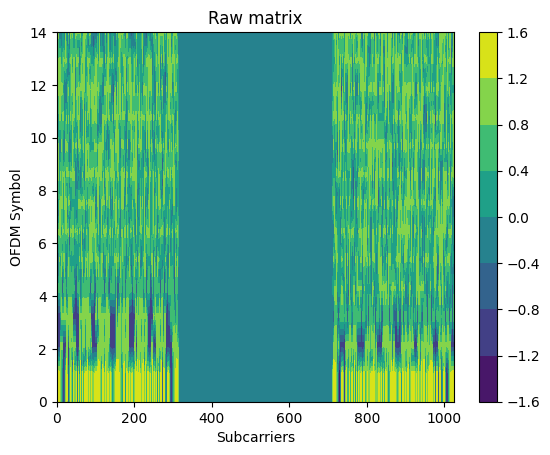

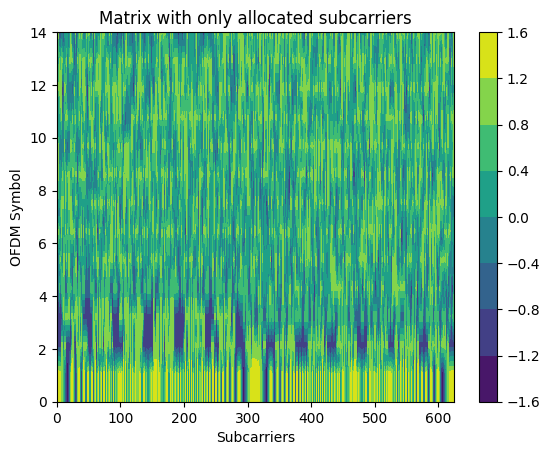

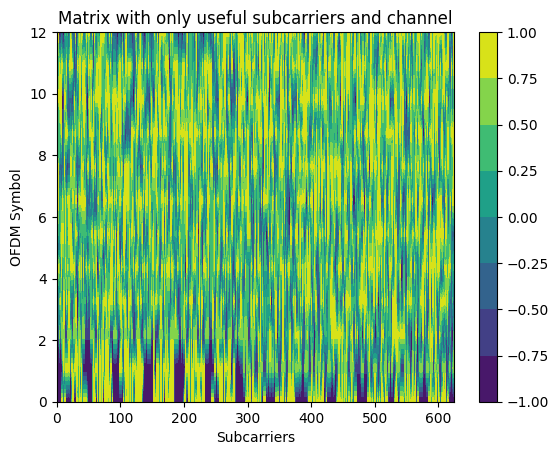

In [3]:
# Load raw matrix
data = np.genfromtxt('./data/tfMatrix.csv', delimiter=';')
tf_matrix = data[:,0::2] + 1j*data[:,1::2]

# Constants
N = 1024 # FFT size
NRe = 624 # Allocated subcarriers

# Print the size of the matrix
# Symbols per frame * FFT size
print("Size of raw matrix: ", tf_matrix.shape)
powerDistributionGraph(tf_matrix, title="Raw matrix", x_label="Subcarriers", y_label="OFDM Symbol")


# Recover only the useful part of the matrix
# 312 first subcarriers and 312 last subcarriers
tf_matrix_short =  np.concatenate([tf_matrix[:,1:NRe // 2 + 1], tf_matrix[:,-NRe // 2:]], axis=1)
print("Size of the matrix with only subcarriers: ", tf_matrix_short.shape)
powerDistributionGraph(tf_matrix_short, title="Matrix with only allocated subcarriers", x_label="Subcarriers", y_label="OFDM Symbol")


# Recover only the useful channel (PBCH, PDCCH, PDSCH)
# The two first OFDM symbols are used for synchronization and channel estimation
qam_matrix = tf_matrix_short[2:,:]
print("Size of the matrix with only subcarriers and useful channel: ", qam_matrix.shape)
powerDistributionGraph(qam_matrix, title="Matrix with only useful subcarriers and channel", x_label="Subcarriers", y_label="OFDM Symbol")

## 1.2. PBCH decoding
## 1.2.1. BPSK decoding

In [7]:
# 1. Check if BPSK symbols don't have imaginary parts
print(qam_matrix[0,0:10])

# 2. Function to demodulates a BPSK stream into a binary stream
def bpsk_demod(stream):
    for i in stream:
        print(i)


bit_seq = bpsk_demod(qam_matrix[0,0:10])

[-1.+0.j -1.+0.j -1.+0.j -1.+0.j -1.+0.j -1.+0.j -1.+0.j -1.+0.j  1.+0.j
  1.+0.j]
(-1+0j)
(-1+0j)
(-1+0j)
(-1+0j)
(-1+0j)
(-1+0j)
(-1+0j)
(-1+0j)
(1+0j)
(1+0j)
